__собираем статистики по объявлениям__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
# import re
# import numpy as np
# from tqdm.notebook import tqdm
import pandas as pd
import geopandas as gpd
# import contextily as ctx
# from shapely.geometry import Polygon

/opt/venv/jupyter_0/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.11.0-CAPI-1.17.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)
# tqdm.pandas()

In [3]:
# !ls -1 data

## считываем данные

In [4]:
data_file = 'data/data_land.pkl'

In [5]:
cols = ['title','adr','latitude','longitude','priceM','ts']
df = pd.read_pickle(data_file)
# df['dt'] = pd.to_datetime( df['ts'].dt.date )
df['dt'] = df['ts'].dt.date
print(len(df))
df.sample(3)[cols]

16199


,title,adr,latitude,longitude,priceM,ts
15092,Участок 4 сот. (ИЖС),"Севастополь,с. Тыловое",44.44,33.72,1.95,2022-11-15 13:16:46.237
15741,Участок 4 сот. (ИЖС),"Севастополь,садоводческое товарищество Рыбак-6, ул. Евгения Алисова, 25",44.569778,33.430525,4.50,2022-11-28 14:58:16.679
5015,"Участок 9,2 сот. (ИЖС)","Севастополь,Пасечный пер., 2А",44.647105,33.587191,4.90,2022-09-16 15:10:34.059


In [6]:
# df.loc[ df['adr_orig']=='Севастополь, Чёрное море', ['latitude','longitude'] ] = None

In [7]:
df.loc[ df['adr_orig'].str.lower().str.match('чёрное море'), ['latitude','longitude'] ] = None 

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16199 entries, 0 to 16198
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   title               16199 non-null  object        
 1   price               16199 non-null  int64         
 2   obj_name            16199 non-null  object        
 3   adr_orig            16199 non-null  object        
 4   description         16199 non-null  object        
 5   avito_page          16199 non-null  int64         
 6   ts                  16199 non-null  datetime64[ns]
 7   place               16199 non-null  object        
 8   area                16199 non-null  float64       
 9   is_IJS              16199 non-null  bool          
 10  priceM              16199 non-null  float64       
 11  priceMU             16199 non-null  float64       
 12  area_size_category  16189 non-null  category      
 13  url                 16199 non-null  object    

In [9]:
df.sample(3)[cols]

,title,adr,latitude,longitude,priceM,ts
5962,Участок 5 сот. (ИЖС),"Севастополь,Античный б-р",44.539133,33.542212,5.00,2022-09-19 12:39:53.571
842,Участок 4 сот. (ИЖС),"Севастополь,ул. Бисти, 3",44.563029,33.538134,3.95,2022-09-08 16:04:40.227
2509,Участок 5 сот. (ИЖС),"Севастополь, Фиолент",44.51,33.50,2.50,2022-09-13 13:56:54.600


In [10]:
# берём объявления с геометкой
print(len(df))
df = df[ (~df['latitude'].isnull()) ].reset_index(drop=True)
print(len(df))

16199
16183


### ограничиваем тип объекта 

In [11]:
# print(len(df))
# # выкидываем "ущербные" варианты 
# df = df.query('is_IJS')
# print(len(df))

In [12]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
gdf.sample(3)[['title','adr','latitude','longitude','priceM']]

,title,adr,latitude,longitude,priceM
8135,Участок 7 сот. (ИЖС),"Севастополь,СТ Энергетик-2",44.573862,33.595482,2.00
5184,Участок 10 сот. (ИЖС),"Севастополь,с. Тенистое, ул. Алиме Абденнановой",44.738672,33.68385,1.40
3417,Участок 1 сот. (ИЖС),"Севастополь,ул. Хрусталёва, 78",44.56,33.52,0.32


In [13]:
del df

In [14]:
gdf[['title','priceM','area_size_category','geometry']].sample(100).explore('area_size_category', legend=True) 

## общая статистика

### количество предложений

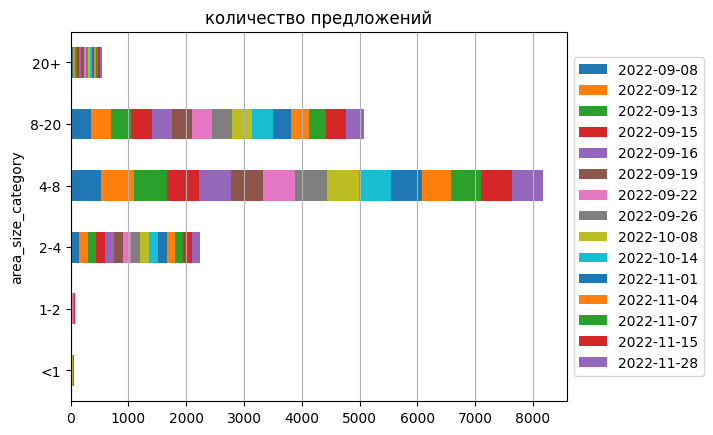

In [15]:
fig = ( # количество предложений
    gdf
    .groupby(['dt','area_size_category'])
    .size().reset_index()
    .pivot(index='area_size_category', columns='dt', values=0)
    .plot
    .barh(legend=False,title='количество предложений',stacked=True)
)
fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.grid(axis='x')

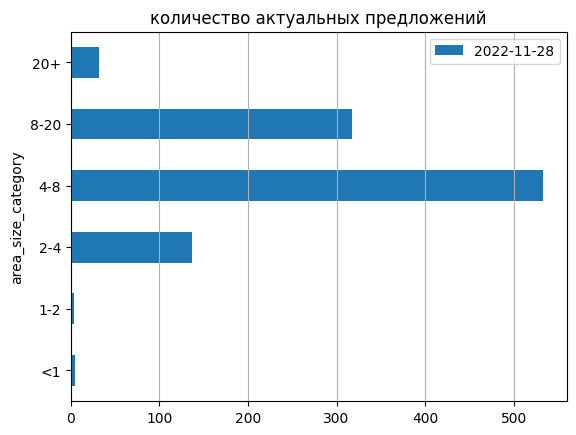

In [16]:
fig = ( # количество актуальных предложений
    gdf[ gdf['dt'] == gdf['dt'].max() ]
    .groupby(['dt','area_size_category'])
    .size().reset_index()
    .pivot(index='area_size_category', columns='dt', values=0)
    .plot
    .barh( legend=False,title='количество актуальных предложений',)#  stacked=True )
)
fig.legend() # loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.grid(axis='x')

### изменение цены

In [17]:
stat = gdf.groupby(['area_size_category','dt'])['priceM'].describe(percentiles=[.01,.1,.25,.5,.75,.9])

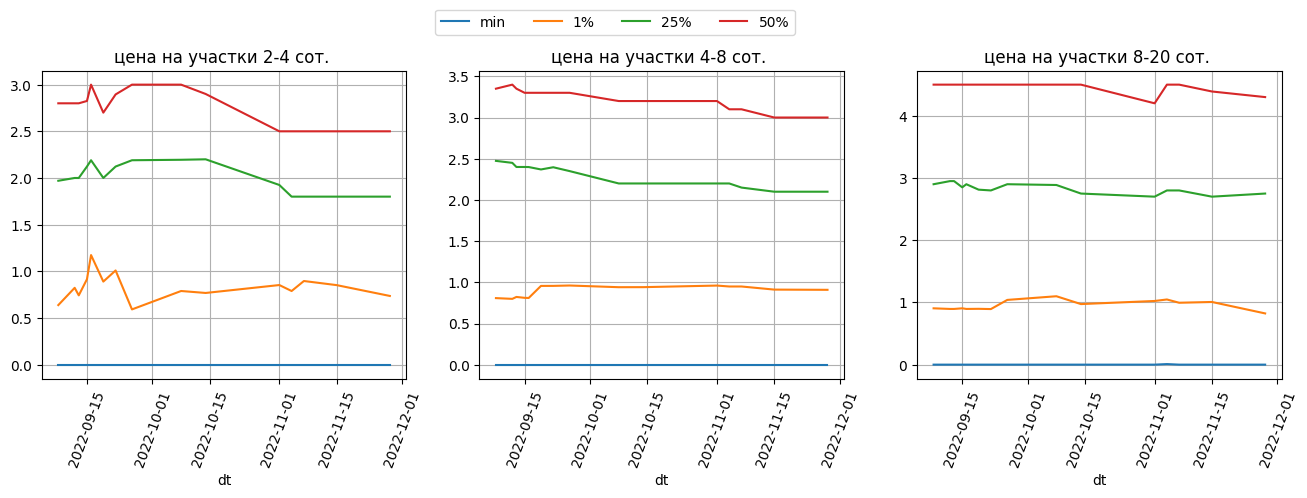

In [18]:
import matplotlib.pyplot as plt

# sizes = [ '<1', '1-2', '2-4', '4-8', '8-20', '20+', ]
# sizes = [ '1-2', '2-4', '4-8', '8-20', ]
sizes = [ '2-4', '4-8', '8-20', ]
cols = ['min','1%','25%','50%']
# fig, ax = plt.subplots(1,len(sizes),figsize=(16,4), sharey=True)
fig, ax = plt.subplots(1,len(sizes),figsize=(16,4), sharey=False)
for i,s in enumerate(sizes): 
    stat.loc[s,cols].plot(grid=True, title=f'цена на участки {s} сот. ',ax=ax[i], legend=False,rot=70)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 1.05))    

### гексагональная сетка и медиана актуальной цены

In [19]:
from shapely.geometry import MultiPoint

frame_all = gpd.GeoDataFrame([{ # все предложения
            'place':'sevastopol', 
            'geometry':MultiPoint( gdf['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

frame_all.explore()

In [20]:
import h3
from shapely.geometry import Polygon
    
def cover_grid_hexagonal(gmtr,cell_size=6,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame({ 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },crs=crs,)

In [21]:
grid = cover_grid_hexagonal( frame_all.geometry.values[0] )
print(len(grid))
grid.sample(2)

36


,hex_id,geometry
25,862d2d40fffffff,"POLYGON ((33.61010 44.91444, 33.58858 44.88512, 33.61556 44.85638, 33.66403 44.85697, 33.68556 44.88628, 33.65860 44.91502, 33.61010 44.91444))"
34,862d28ba7ffffff,"POLYGON ((33.85737 44.59725, 33.83587 44.56788, 33.86263 44.53903, 33.91086 44.53955, 33.93237 44.56891, 33.90563 44.59776, 33.85737 44.59725))"


In [22]:
grid_values = ( 
    grid
    .sjoin( gdf[ gdf['dt']==gdf['dt'].max() ], how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

## ограничиваем по район поиска

In [23]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
    { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
    for nm,f in frames_index.values
],crs='epsg:4326',)

frames

,area_name,geometry
0,"Севастополь, район Острякова","POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))"
1,"Севастополь, парк 60-летия СССР","POLYGON ((33.51805 44.58404, 33.51458 44.58408, 33.51263 44.58031, 33.51435 44.57460, 33.52004 44.57520, 33.51805 44.58404))"
2,"Севастополь, Хрусталёва/Хрюкина","POLYGON ((33.52003 44.57511, 33.52527 44.56364, 33.52116 44.56136, 33.51942 44.56406, 33.51951 44.56384, 33.51874 44.56882, 33.51426 44.57444, 33.52003 44.57511))"
3,"Севастополь, Геловани/Коломийца","POLYGON ((33.52139 44.57296, 33.53034 44.57518, 33.53318 44.57413, 33.53369 44.57139, 33.53244 44.56878, 33.53123 44.56774, 33.52440 44.56640, 33.52139 44.57296))"
4,"Севастополь, Музыки/Бирюзова","POLYGON ((33.52027 44.57528, 33.51724 44.58719, 33.52038 44.58724, 33.52554 44.58091, 33.52561 44.57790, 33.52027 44.57528))"
5,"Севастополь, кр.горка","POLYGON ((33.53426 44.59526, 33.54470 44.58945, 33.54804 44.58596, 33.55346 44.58519, 33.55707 44.57912, 33.56296 44.57711, 33.54048 44.56941, 33.53004 44.59308, 33.53426 44.59526))"
6,"Севастополь, Малахов курган","POLYGON ((33.54313 44.60612, 33.55331 44.61155, 33.55676 44.60803, 33.55772 44.60255, 33.55385 44.60019, 33.54414 44.60247, 33.54313 44.60612))"


In [24]:
frames.explore('area_name')

In [25]:
area_name=[
#'Севастополь, парк 60-летия СССР',
#'Севастополь, Хрусталёва/Хрюкина',
#'Севастополь, район Острякова',
'Севастополь, кр.горка',
]

# выбираем область
frame_ = frames[frames['area_name'].isin(area_name)]

# фильтруем данные по области
print(len(gdf))
gdf_ = gdf.sjoin( frame_, how='inner', predicate='within') 
print(len(gdf_))

16183
530


In [26]:
# новые (актуальные) предложения
cols=['title','priceM','adr','area_size_category','geometry']
gdf_[ gdf_['dt']==gdf_['dt'].max() ][cols].explore( 'area_size_category',legend=True)

In [27]:
locations = ' | '.join(area_name)
locations

'Севастополь, кр.горка'

### количество предложений

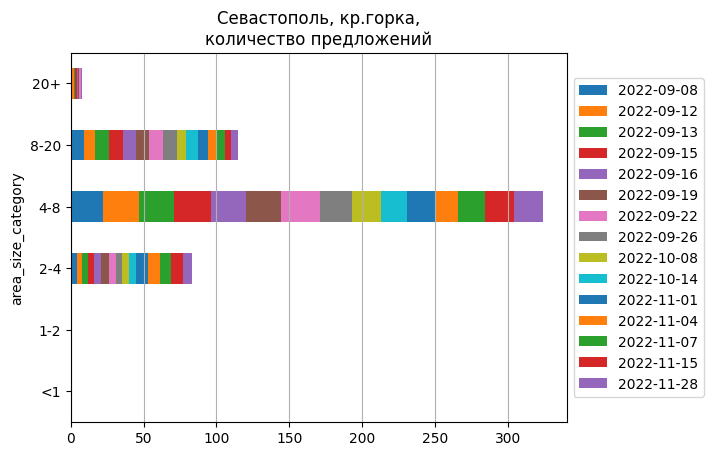

In [28]:
fig = ( # количество предложений
        gdf_
        .groupby(['dt','area_size_category'])
        .size().reset_index()
        .pivot(index='area_size_category', columns='dt', values=0)
        .plot
        .barh(legend=False,title=f'{locations},\nколичество предложений',stacked=True)
    )
fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.grid(axis='x')


In [29]:
# ( 
#     gdf_[ gdf_['dt'] == gdf_['dt'].max() ]
#     .groupby(['dt','area_size_category'])
#     .size().reset_index()
#     .pivot(index='area_size_category', columns='dt', values=0)
# )#.info()

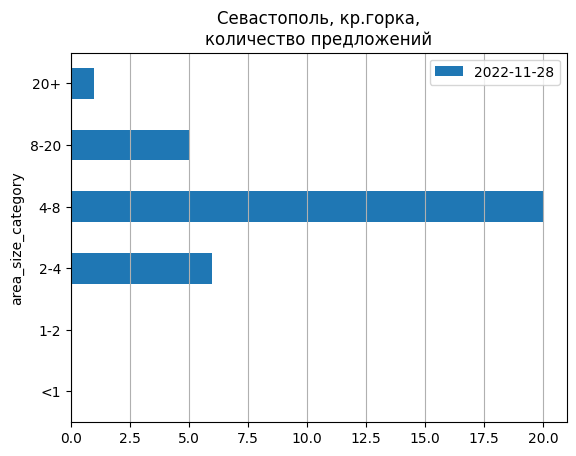

In [30]:
fig = ( # количество актуальных предложений
    gdf_[ gdf_['dt'] == gdf_['dt'].max() ]
    .groupby(['dt','area_size_category'])
    .size().reset_index()
    .pivot(index='area_size_category', columns='dt', values=0)
    .plot.barh( legend=False,title=f'{locations},\nколичество предложений')#, stacked=True )
)
fig.legend() #loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.grid(axis='x')

### изменение цены

In [31]:
stat = gdf_.groupby(['area_size_category','dt'])['priceM'].describe(percentiles=[.01,.1,.25,.5,.75,.9])

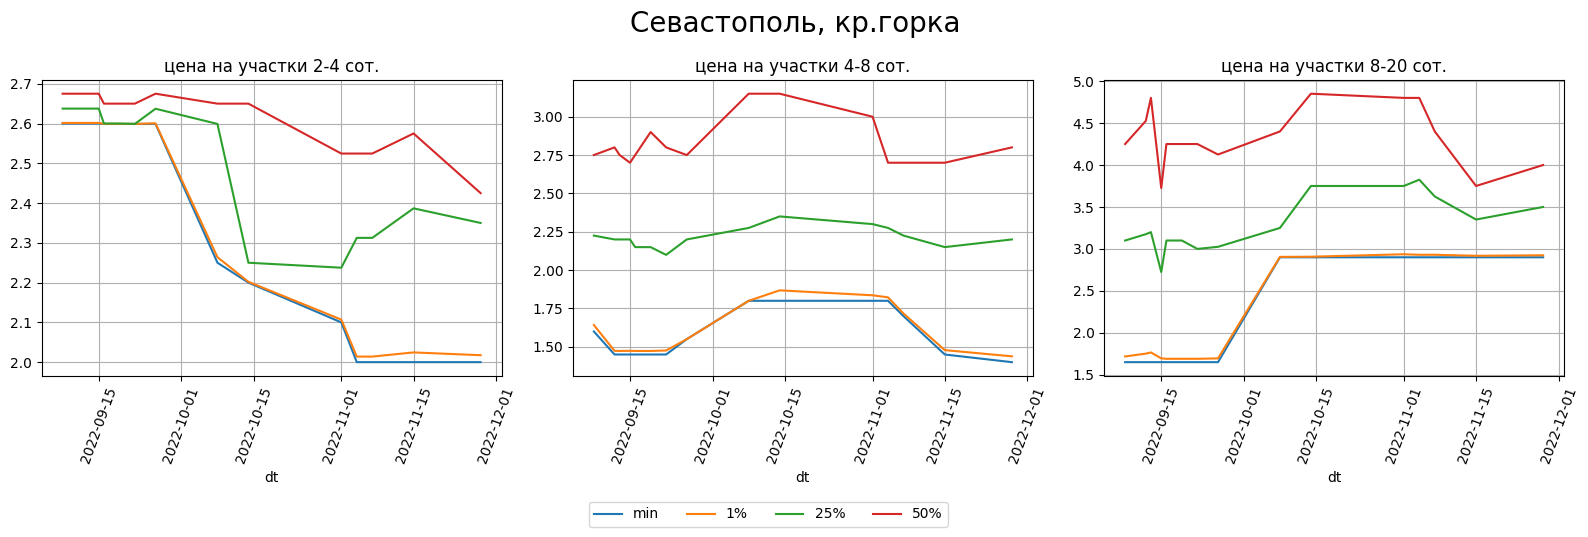

In [32]:
import matplotlib.pyplot as plt

# sizes = [ '<1', '1-2', '2-4', '4-8', '8-20', '20+', ]
# sizes = [ '1-2', '2-4', '4-8', '8-20', ]
sizes = [ '2-4', '4-8', '8-20', ]
cols = ['min','1%','25%','50%']
# fig, ax = plt.subplots(1,len(sizes),figsize=(16,4), sharey=True)

fig, ax = plt.subplots(1,len(sizes),figsize=(16,5), sharey=False) #,title=locations)
for i,s in enumerate(sizes): 
    stat.loc[s,cols].plot(
        grid=True, 
        title=f'цена на участки {s} сот.',
        ax=ax[i], 
        legend=False,
        rot=70,
    )
fig.suptitle(locations, fontsize=20)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()
# plt.show()

### гексагональная сетка и медиана актуальной цены

In [33]:
grid = cover_grid_hexagonal( frame_.geometry.values[0], cell_size=9 )
print(len(grid))
grid.sample(2)

32


,hex_id,geometry
23,892d289438bffff,"POLYGON ((33.53962 44.59161, 33.53929 44.58982, 33.54138 44.58866, 33.54379 44.58929, 33.54411 44.59107, 33.54203 44.59224, 33.53962 44.59161))"
21,892d289435bffff,"POLYGON ((33.54666 44.57980, 33.54633 44.57801, 33.54842 44.57685, 33.55083 44.57748, 33.55115 44.57927, 33.54907 44.58043, 33.54666 44.57980))"


In [34]:
grid_values = (
    grid
    .sjoin( gdf[ gdf['dt'] == gdf['dt'].max() ], how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)